In [7]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic


In [71]:
def radial_fdm_laplacian(r_max, n, left_bc = 'neumann'):
    """Generate laplacian in 2d polar coordinates, radial part.
    
    Discretize [0, r_max] with n+2 points, and apply
    neumann conditions on r=0 and Dirichlet on r=r_max, 
    resulting in an nxn matrix for the inner grid points.
    
    Args:
        r_max (float): right endpoint
        n (int): number of inner grid points
        left_bc (str, optional): 'neumann' for neumann BC, else dirichlet.
    
    Returns:
        ndarray: Laplacian as CRS matrix
        r: radial grid with endpoints
        G: transition matrix from inner to global grid
    
    """
    r = np.linspace(0, r_max, n+2)
    L = np.zeros((n,n+2))
    h = r[1]-r[0]
    
    for i in range(1,n+1):
        L[i-1,i+1] = (r[i]+h/2)/r[i]
        L[i-1,i-1] = (r[i]-h/2)/r[i]
        L[i-1,i] = -2 #-(r[i] + h/2)/r[i] - (r[i] - h/2)/r[i]
    
    G = np.zeros((n+2,n))
    G[1:-1,:] = np.eye(n)
    if left_bc == 'neumann':
        G[0,0] = 4/3
        G[0,1] = -1/3
    else:
        pass
    
    L1 = L @ G / h**2
    return L1, r, G

In [96]:
m = 0

L, r0, G = radial_fdm_laplacian(10, 100, left_bc = 'neumann' if m == 0 else 'dirichlet')
r = r0[1:-1]
H = -0.5*L + np.diag(r**2/2 + .5*m**2/r**2)



In [97]:
E, U = np.linalg.eig(H)
i = np.argsort(E)
E = E[i]
U = U[:,i]
E

array([  0.99879998,   2.99399285,   4.98436097,   6.96988313,
         8.95053786,  10.92630349,  12.8971581 ,  14.86307956,
        16.82404552,  18.7800334 ,  20.73102042,  22.67698356,
        24.61789958,  26.55374499,  28.48449609,  30.41012893,
        32.33061937,  34.24594377,  36.1560849 ,  38.06107444,
        39.96122985,  41.85814449,  43.75754103,  45.6739174 ,
        47.63180193,  49.65753335,  51.76812425,  53.96866029,
        56.25679956,  58.62736807,  61.07469159,  63.59339312,
        66.17855005,  68.82565008,  71.53050531,  74.28917258,
        77.0978898 ,  79.95302794,  82.85105523,  85.78851069,
        88.76198456,  91.76810389,  94.8035218 ,  97.86490973,
       100.9489517 , 104.05234033, 107.17177404, 110.30395528,
       113.44558945, 116.59338446, 119.74405069, 122.89430127,
       126.04085269, 129.18042539, 132.30974464, 135.42554127,
       138.52455245, 141.60352232, 144.65920247, 147.68835213,
       150.68773802, 153.65413379, 156.58431891, 159.47

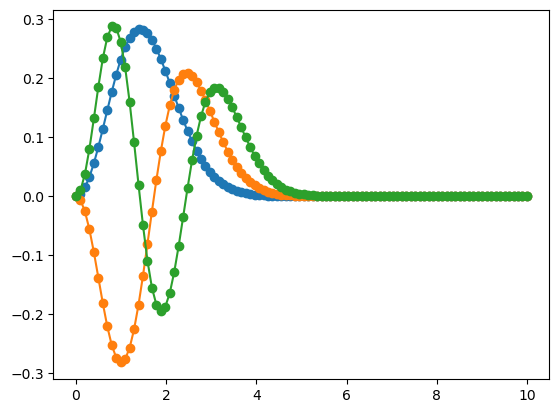

In [93]:
plt.figure()
plt.plot(r0,G@U[:,:3], 'o-')
plt.show()